In [1]:
import fixed_utils as ut
import cv2
from matplotlib import image as im
from matplotlib import pyplot as plt
import numpy as np
import random
from itertools import product

In [2]:
img1 = 'hw2_data/uttower_left.JPG'
img2 = 'hw2_data/uttower_right.JPG'

## Read the images

In [3]:
left_color = im.imread(img1)
right_color = im.imread(img2)

(683, 1024, 3)

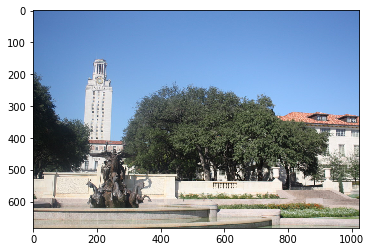

In [6]:
plt.imshow(left_color)
left_color.shape

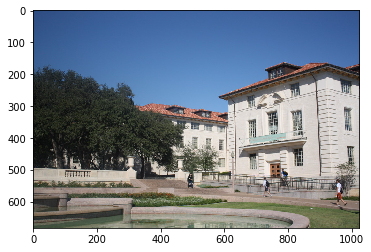

In [7]:
plt.imshow(right_color)

## Convert the images into grayscale

`left` is the left image in grayscale

`right` is the right image in grayscale

In [10]:
left = cv2.cvtColor(left_color, cv2.COLOR_BGR2GRAY)
right = cv2.cvtColor(right_color, cv2.COLOR_BGR2GRAY)

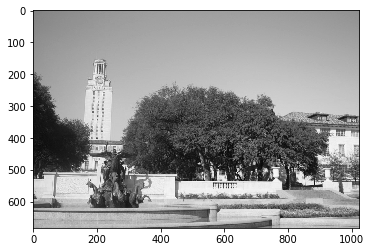

In [11]:
plt.imshow(left, cmap="gray")

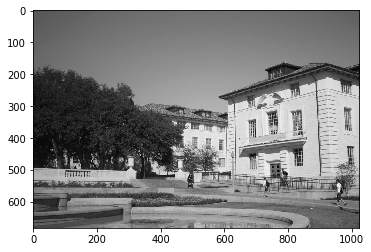

In [12]:
plt.imshow(right, cmap="gray")

## Find the harris features in both the images

specify `thresh` and `radius`

In [13]:
thresh = 20
radius = 17
features_left_image, left_r, left_c = ut.harris(left, 2, thresh, radius)
features_right_image, right_r, right_c = ut.harris(right, 2, thresh, radius)

## Plotting the Harris features found in the image

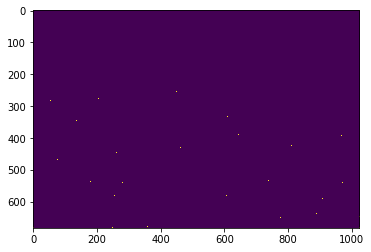

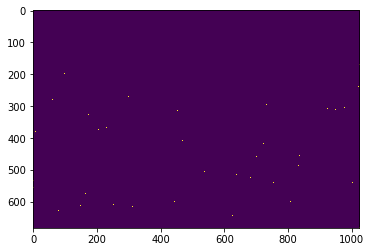

In [14]:
for im in [features_left_image, features_right_image]:
    plt.figure()
    plt.imshow(im)

## Get the coordinates of the feature points in both the images

In [15]:
left_feature_coords = np.array(list(zip(left_r, left_c)))
right_feature_coords = np.array(list(zip(right_r, right_c)))

## Use the coordinates of the harris feature points to show the features on the image

The following image is saved as `left_features.png`

True

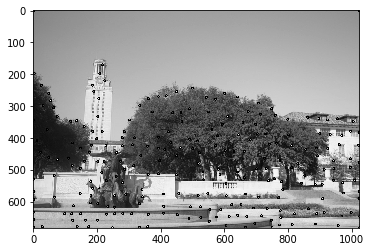

In [16]:
white = 255
temp_left = np.copy(left)
for pixel in left_feature_coords:
    cv2.circle(temp_left,(pixel[1],pixel[0]),3,(0,0,255),2)
    temp_left[pixel[0],pixel[1]] = white
plt.imshow(temp_left, cmap='gray')
cv2.imwrite("left_features.png", temp_left)

The following image is saved as `right_features.png`

True

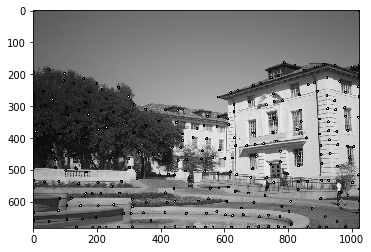

In [17]:
white = 255
temp_right = np.copy(right)
for pixel in right_feature_coords:
    cv2.circle(temp_right,(pixel[1],pixel[0]),3,(0,0,255),2)
    temp_right[pixel[0],pixel[1]] = white
plt.imshow(temp_right, cmap='gray')
cv2.imwrite("right_features.png", temp_right)

## Finding descriptors using harris keypoints

In [18]:
neighborhood_radius = 20
left_circles = np.zeros((len(left_feature_coords), 3))
for i,pixel in enumerate(left_feature_coords):
    left_circles[i]=[pixel[0],pixel[1], neighborhood_radius]
left_sift_descriptors = ut.find_sift(left, left_circles)

In [19]:
right_circles = np.zeros((len(right_feature_coords), 3))
for i,pixel in enumerate(right_feature_coords):
    right_circles[i]=[pixel[0],pixel[1], neighborhood_radius]
right_sift_descriptors = ut.find_sift(right, right_circles)

## Get distances between the descriptors

In [20]:
distances = ut.dist2(left_sift_descriptors, right_sift_descriptors)

## Find the pairs of points between the two images that form a match

In [21]:
pairs_of_circles = list(product(tuple(map(tuple,right_circles)), tuple(map(tuple, left_circles))))

## Find the putative points by sorting them based on the distance between their descriptors

In [22]:
desired_num_points = 60
smallest = distances.flatten().argsort()[:desired_num_points]
desired_points = np.array([pairs_of_circles[i] for i in smallest])
desired_points.shape

(60, 2, 3)

## Show these points on the image

The following image is saved as `putative_left.png`

True

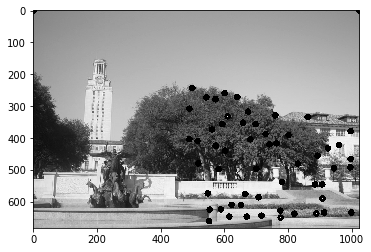

In [23]:
white = 255
temp_left = np.copy(left)
temp_features_left = [(int(i[1][0]), int(i[1][1])) for i in desired_points]
for pixel in temp_features_left:
    cv2.circle(temp_left,(pixel[1],pixel[0]),5,(0,0,255),10)
    temp_left[pixel[0],pixel[1]] = white
plt.imshow(temp_left, cmap='gray')
cv2.imwrite("putative_left.png", temp_left)

The following image is saved as `putative_right.png`

True

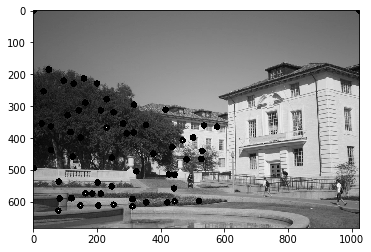

In [24]:
white = 255
temp_right = np.copy(right)
temp_features_right = [(int(i[0][0]), int(i[0][1])) for i in desired_points]
for pixel in temp_features_right:
    cv2.circle(temp_right,(pixel[1],pixel[0]),5,(0,0,255),10)
    temp_right[pixel[0],pixel[1]] = white
plt.imshow(temp_right, cmap='gray')
cv2.imwrite("putative_right.png", temp_right)

In [25]:
pts_src = np.array(temp_features_left)
pts_dest = np.array(temp_features_right)
pts_src = np.array(list(map(lambda t: (t[1],t[0]), pts_src)))
pts_dest = np.array(list(map(lambda t: (t[1],t[0]), pts_dest)))

## Find Homography

In [26]:
def calculateHomography(sample):
    # assemble matrix
    alist = []
    for pairs in sample:
        # x1, y1
        p1 = np.matrix([pairs[0][1], pairs[0][0], 1])
        p2 = np.matrix([pairs[1][1], pairs[1][0], 1])
        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        alist.append(a1)
        alist.append(a2)
    matrixA = np.matrix(alist)
    u, s, v = np.linalg.svd(matrixA)
    h = np.reshape(v[8], (3, 3))
    h = (1/h.item(8)) * h
    return h
        

In [27]:
def geometricDistance(correspondence, h):

    p1 = np.transpose(np.matrix([correspondence[0][1], correspondence[0][0], 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[1][1], correspondence[1][0], 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

## running RANSAC to find the homography

In [44]:
maxInliers = []
finalH = None
thresh = 0.60
for i in range(1000):
    sample = random.sample(list(desired_points), 4)
    H = calculateHomography(sample)
    inliers = []
    for i in range(len(desired_points)):
        d = geometricDistance(desired_points[i], H)
        if d < 5:
            inliers.append(desired_points[i])
    
    if len(inliers) > len(maxInliers):
        maxInliers = inliers
        finalH = H
    if len(maxInliers) > len(desired_points)*thresh:
        break

## Stitched image

The stitched image is saved as `Stitched_image.png`

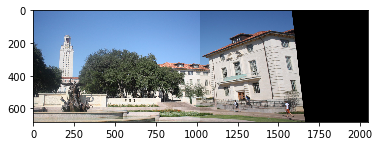

In [45]:
img_dst = cv2.warpPerspective(right_color, finalH, (right.shape[1]+right.shape[1], right.shape[0]))
img_dst[0:left.shape[0], 0:left.shape[1]] = left_color
plt.imshow(img_dst)
plt.imsave("Stitched_image.png", img_dst)

In [33]:
print("Maximum number of inliers are:", len(maxInliers))

Maximum number of inliers are: 38
